In [ ]:
# Instalar Roboflow y descargar dataset
!pip install roboflow

from roboflow import Roboflow
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torch
from torch import nn, optim
from torchvision import models
from timm import create_model

# Descargar el dataset desde Roboflow
rf = Roboflow(api_key="3rAKozTp5vKr2981hco7")
project = rf.workspace("ml-n2gfx").project("modelo-de-deteccion-de-accidente")
version = project.version(4)
dataset = version.download("folder")

# Definir las rutas del dataset
train_dir = os.path.join(dataset.location, 'train')
valid_dir = os.path.join(dataset.location, 'valid')

# Definir transformaciones para las imágenes
transform = Compose([
    Resize((224, 224)),  # Cambiar tamaño a 224x224
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalización
])

# Cargar el dataset con ImageFolder
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=valid_dir, transform=transform)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Etiquetas de clase
num_classes = len(train_dataset.classes)

# Cargar modelo preentrenado ViT
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

# Congelar capas base (opcional)
for param in model.parameters():
    param.requires_grad = False

# Entrenar solo la última capa (clasificación)
for param in model.head.parameters():
    param.requires_grad = True

# Definir función de pérdida, optimizador y métrica
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=1e-4)

# Usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Función para entrenar el modelo
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

# Función para evaluar el modelo
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

# Entrenar el modelo
epochs = 5
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Guardar el modelo entrenado
torch.save(model.state_dict(), "fine_tuned_vit.pth")
print("Modelo guardado como 'fine_tuned_vit.pth'")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Modelo-de-deteccion-de-Accidente-4 in folder:: 100%|██████████| 3951/3951 [00:03<00:00, 1212.71it/s]

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/5
  Train Loss: 0.2246, Train Acc: 0.9269
  Val Loss: 0.0651, Val Acc: 0.9975
Epoch 2/5
  Train Loss: 0.0504, Train Acc: 0.9924
  Val Loss: 0.0337, Val Acc: 0.9975
Epoch 3/5
  Train Loss: 0.0314, Train Acc: 0.9938
  Val Loss: 0.0234, Val Acc: 0.9975
Epoch 4/5
  Train Loss: 0.0230, Train Acc: 0.9960
  Val Loss: 0.0182, Val Acc: 0.9975
Epoch 5/5
  Train Loss: 0.0180, Train Acc: 0.9967
  Val Loss: 0.0147, Val Acc: 0.9987
Modelo guardado como 'fine_tuned_vit.pth'


In [ ]:
import torch
from timm import create_model

# Número de clases (especifica el valor correcto)
num_classes = 2  # Cambia esto al número correcto según tu modelo entrenado

# Crear el modelo con la misma arquitectura usada durante el entrenamiento
model = create_model('vit_base_patch16_224', pretrained=False, num_classes=num_classes)

# Cargar los pesos entrenados
model.load_state_dict(torch.load("fine_tuned_vit.pth", map_location=torch.device('cpu')))
model.eval()  # Cambiar a modo de evaluación

print("Modelo cargado exitosamente y listo para hacer predicciones.")


<ipython-input-1-4c6f90946be7>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fine_tuned_vit.pth", map_location=torch.device('cpu')))


Modelo cargado exitosamente y listo para hacer predicciones.


In [ ]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Transformaciones para la imagen
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalización
])

# Cargar la imagen
image_path = "ruta_de_tu_imagen.jpg"  # Cambia esto por la ruta de tu imagen
image = Image.open('/content/2.jpg').convert("RGB")  # Asegúrate de que sea RGB
input_tensor = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch

# Verifica que todo está correcto
print("Shape de la imagen procesada:", input_tensor.shape)  # Debe ser [1, 3, 224, 224]


Shape de la imagen procesada: torch.Size([1, 3, 224, 224])


In [ ]:
# Predicción con el modelo
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = output.argmax(1).item()  # Índice de la clase con mayor probabilidad

# Obtener el nombre de la clase
# Definir los nombres de las clases manualmente
class_names = ["Normal", "Accidente"]  # Sustituye por tus clases reales

# Obtener la predicción
predicted_class = output.argmax(1).item()  # Índice de la clase predicha
print(f"Predicción: {class_names[predicted_class]}")



Predicción: Normal


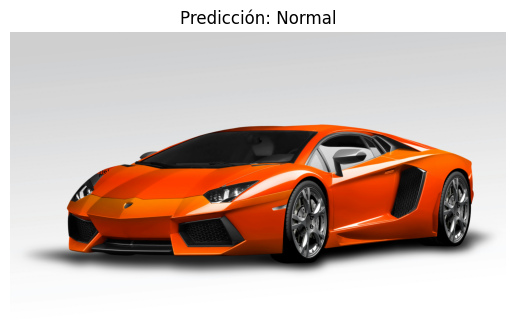

In [ ]:
import matplotlib.pyplot as plt

# Mostrar la imagen y la predicción
plt.imshow(image)
plt.title(f"Predicción: {class_names[predicted_class]}")
plt.axis("off")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def get_predictions_and_labels(model, loader):
    model.eval()  # Cambiar a modo evaluación
    y_true = []  # Etiquetas reales
    y_pred = []  # Predicciones

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)  # Obtener la clase con mayor probabilidad
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)


In [ ]:
# Obtener predicciones y etiquetas reales
y_true, y_pred = get_predictions_and_labels(model, val_loader)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

print("Matriz de confusión:")
print(conf_matrix)


Matriz de confusión:
[[387   0]
 [  1 401]]


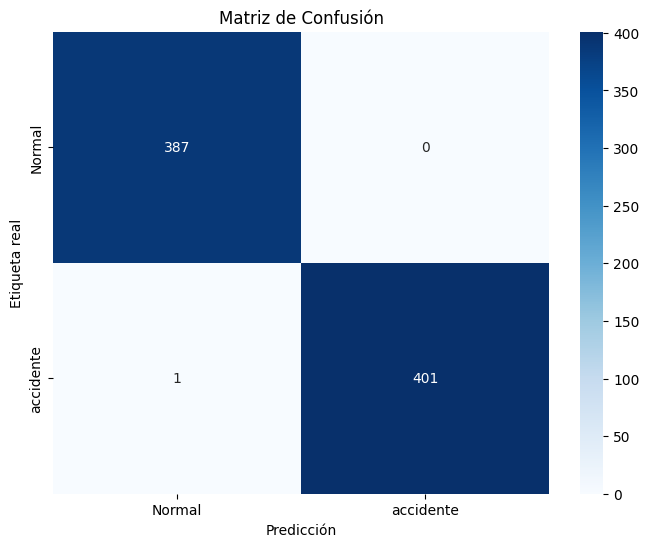

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión')
plt.show()


In [ ]:
from sklearn.metrics import recall_score

def calculate_recall(model, loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)  # Convertir a índices de clase
            y_true.extend(labels.cpu().numpy())  # Convertir a numpy
            y_pred.extend(preds.cpu().numpy())

    # Calcular recall
    recall = recall_score(y_true, y_pred, average='macro')  # Promedio macro para multiclase
    return recall


In [ ]:
# Calcular el recall en el conjunto de validación
recall = calculate_recall(model, val_loader)
print(f"Recall en validación: {recall:.4f}")


Recall en validación: 0.9988
